## Introduction
This is an implementation of FixMatch in fastai.

This semi-supervised learning algorithm combines consistency regularization and pseudo-labelling to make use of unlabeled data. 

Weakly-augmented unlabeled images are fed to a model. 

If a prediction is above a confidence threshold, it is retained as a pseudo-label. 
Then, the model is trained to predict the same pseudo-label from a strongly-augmented version of the same image.

https://arxiv.org/abs/2001.07685

<img src="https://miro.medium.com/max/1400/1*5SCSOqvXcrxL-IwZmZaH_g.png"/>


This still needs to be improved.

But it can run with any custom dataset and can take any fastai or torchvision transforms

Inspiration for this code:

https://github.com/oguiza/fastai_extensions/blob/master/04a_MixMatch_extended.ipynb

https://github.com/kekmodel/FixMatch-pytorch




## User Guide



1. Create the labeled databunch in the regular fastai fashion.


```
labeled_data = (ImageList.from_df(img_df, labeled_img_dir, cols="filename")
  .split_by_rand_pct(0.2)
  .label_from_df("majority_label")
  .transform(get_transforms(), size=train_image_size)
  .databunch(bs=batch_size)
  .normalize()
)```





2. Define the weak and strong transformations, using fastai and/or torchvision transforms.

The current flow is: apply fastai transforms if defined, then apply torchvision tranforms if defined


```
def get_weak_transforms():
  weak_transforms = get_transforms()[0]
  return weak_transforms

def get_strong_transforms():
  strong_transforms = get_transforms(max_rotate=20, max_zoom=1.2,
    max_lighting=0.5, max_warp=0.5,
  )[0]
  return strong_transforms

def get_extra_strong_transforms():
  custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomCrop(300, pad_if_needed=True, padding_mode="reflect"),
    torchvision.transforms.Resize(train_image_size),
    torchvision.transforms.ColorJitter(0, 0, 0.9, 0.2),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.ToPILImage(),
  ])
  return custom_transforms
  ```



3. Create the unlabeled databunch, for example the function get_unlabeled_data.

The required input is: the path to the unlabeled data directory, and the labeled databunch (for normalization statistics and the batch size multiplier)

The important hyperparameter here is batch multiplier (mu in the paper)

unlabeled batch size = labeled batch size * mu


```
def get_unlabeled_data(unlabeled_dir, labeled_data, n_augment=2, batch_multiplier=2):
    u_image_list = ImageList.from_folder(unlabeled_dir).split_none()
    u_image_list.train._label_list = partial(MultiTfmPairLabelList, K=n_augment, 
                                             weak_tfms=get_weak_transforms(), strong_tfms=get_strong_transforms(),
                                             extra_strong_tfms=get_extra_strong_transforms())
    u_databunch = (u_image_list.label_empty()
        .databunch(
            bs=labeled_data.batch_size * batch_multiplier,
            collate_fn=MultiCollate)
        .normalize(labeled_data.stats))
    u_databunch.c = 1
    return u_databunch
```



4. Create the Learner in the usual manner, then append the call to fixmatch extension while passing the unlabeled databunch.

The important hyperparameter here is unlabeled_loss_coeff (Lambda u in the paper)

Final loss = labeled loss + unlabeled loss coeff * unlabeled loss


```
base_model = models.resnet18()
learn = Learner(labeled_data, base_model, metrics=accuracy).fixmatch(unlabeled_data)
```



5. Everything is ready, use lr_find and fit_one_cycle as habitual

## Code

In [0]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
from pathlib import Path
import sys
import pdb
import logging
import traceback

import pandas as pd

shared_pizza_dir = Path("/content/drive/My Drive/FellowshipAI/pizza-doneness/")

labeled_dir = shared_pizza_dir.joinpath("images")
labeled_img_dir = shared_pizza_dir.joinpath("images", "combined-images", "combined_images_copy")
unlabeled_img_dir = shared_pizza_dir.joinpath("backups", "Food101N-dedup", "pizza")

The dataset in this example is pizza doneness.

Pizza images are classified into 1 of 3 categories: light, medium, dark.

This task is actually much harder than it appears. Thus, the performance of the model is average.

In [0]:

img_df = pd.read_csv(labeled_dir.joinpath("majority_label_final.csv"), index_col=0)
print(img_df.shape)
display(img_df.sample(10))


(1006, 2)


,filename,majority_label
379,Enrico_google images_quiche-crue1-1100x500_c_3...,light
754,Enrico_google images_pizza-crue-43044925_377.jpg,light
808,Enrico_google images_1687323_317.jpg,light
374,Enrico_google images_pizza-napoletana-fatta-in...,medium
579,Enrico_google images_grapefruit-brulee_687.jpg,medium
341,Enrico_google images_gros-plan-savoureuse-pizz...,light
884,Enrico_google images_PHOTO-2018-12-14-15-52-49...,medium
587,Enrico_google images_pic87Cd0I_751.jpg,medium
74,Enrico_google images_frozen-pizza_397.jpg,medium
327,Enrico_google images_depositphotos_256239012-s...,light


In [0]:
from functools import partial

import fastai
from fastai.vision import *

from fastai.basic_train import LearnerCallback, Learner, DataBunch, SmoothenValue, to_data, functools, \
    add_metrics, Module, nn
from fastai.imports import torch, F

import numpy as np
from torch.utils.data import Dataset

from numbers import Integral
import gc

import torchvision

Big batch size may lead to out of GPU memory error

In [0]:
batch_size = 16
train_image_size = (128, 128)


Create the labeled data in any regular fastai fashion

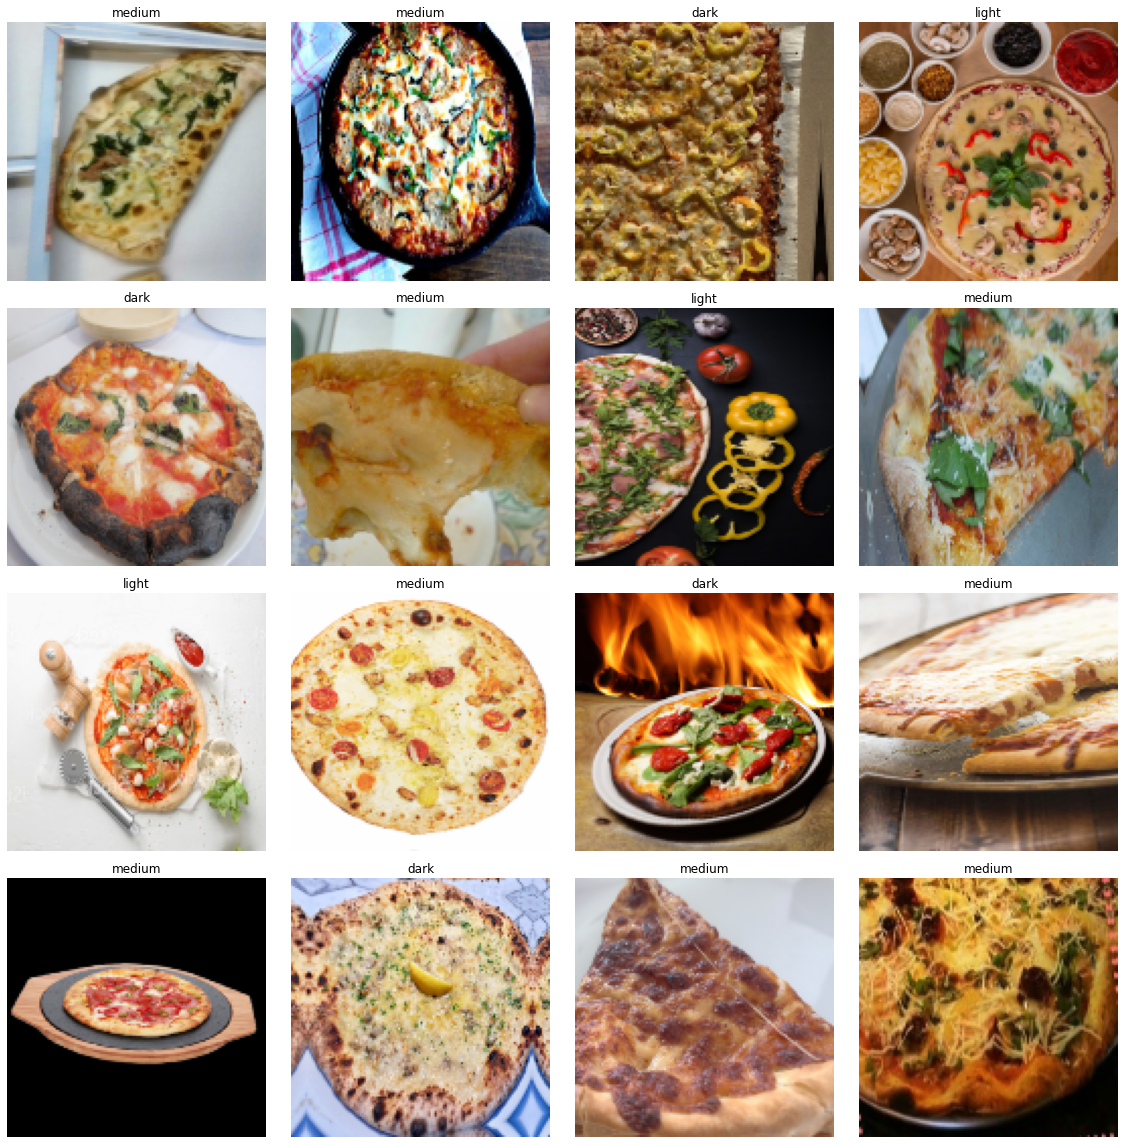

In [0]:
labeled_data = (ImageList.from_df(img_df, labeled_img_dir, cols="filename")
  .split_by_rand_pct(0.2)
  .label_from_df("majority_label")
  .transform(get_transforms(), size=train_image_size)
  .databunch(bs=batch_size)
  .normalize()
)

labeled_data.show_batch()

## FixMatch code

In [0]:

class MultiTfmLabelList(LabelList):
    def __init__(self, x:ItemList, y:ItemList, tfms:TfmList=None, tfm_y:bool=False, K=2, **kwargs):
        "K: number of transformed samples generated per item"
        self.x,self.y,self.tfm_y,self.K = x,y,tfm_y,K
        self.y.x = x
        self.item=None
        self.transform(tfms, **kwargs)
        
    def __getitem__(self,idxs:Union[int, np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.tfms or self.tfmargs:
                x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(self.K)]
            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])

def MultiCollate(batch):
    batch = to_data(batch)
    if isinstance(batch[0][0],list): batch = [[torch.stack(s[0]),s[1]] for s in batch]
    return torch.utils.data.dataloader.default_collate(batch)



In [0]:

class FixMatchLoss(Module):

    def __init__(self, reduction='mean', unlabeled_loss_coeff=1.0, threshold=0.95):
        super().__init__()
        crit = nn.CrossEntropyLoss()
        if hasattr(crit, 'reduction'):
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else:
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction
        self.unlabeled_loss_coeff = unlabeled_loss_coeff
        self.threshold = threshold

    def forward(self, preds, target, bs=None):

        if bs is None: return F.cross_entropy(preds, target)

        # labeled_preds = torch.log_softmax(preds[:bs], dim=1)       
        # Lx = -(labeled_preds * target[:bs]).sum(dim=1).mean()
        # Lx = -(labeled_preds[range(labeled_preds.shape[0]), target[:bs]]).mean()
        
        Lx = F.cross_entropy(preds[:bs], target[:bs])
        self.Lx = Lx.item()

        logits_u_w, logits_u_s = preds[bs:].chunk(2)

        pseudo_label = torch.softmax(logits_u_w.detach_(), dim=-1)
        max_probs, targets_u = torch.max(pseudo_label, dim=-1)
        mask = max_probs.ge(self.threshold).float()

        Lu = (F.cross_entropy(logits_u_s, targets_u, reduction='none') * mask).mean()

        self.Lu = (Lu * self.unlabeled_loss_coeff).item()

        return Lx + Lu * self.unlabeled_loss_coeff

    def get_old(self):
        if hasattr(self, 'old_crit'):
            return self.old_crit
        elif hasattr(self, 'old_red'):
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit


class FixMatchCallback(LearnerCallback):
    _order = -20

    def __init__(self,
                 learn: Learner,
                 unlabeled_data: DataBunch,
                 unlabeled_loss_coeff: float = 1):
        super().__init__(learn)

        self.learn, self.unlabeled_loss_coeff = learn, unlabeled_loss_coeff
        self.unlabeled_dl = unlabeled_data.train_dl
        self.n_classes = unlabeled_data.c
        self.unlabeled_data = unlabeled_data

    def on_train_begin(self, n_epochs, **kwargs):
        self.learn.loss_func = FixMatchLoss(unlabeled_loss_coeff=self.unlabeled_loss_coeff)
        self.uldliter = iter(self.unlabeled_dl)
        self.smoothLx, self.smoothLu = SmoothenValue(0.98), SmoothenValue(0.98)
        self.recorder.add_metric_names(["train_Lx", "train_Lu*λ"])
        self.it = 0
        print('labeled dataset     : {:13,} samples'.format(len(self.learn.data.train_ds)))
        print('unlabeled dataset   : {:13,} samples'.format(len(self.unlabeled_data.train_ds)))
        print("labeled batch size:", learn.data.batch_size)
        print("unlabeled batch size:", unlabeled_data.batch_size)
        # total_samples = n_epochs * len(self.learn.data.train_dl) * \
        #                 self.learn.data.train_dl.batch_size * (self.label_list.K + 1)
        # print('total train samples : {:13,} samples'.format(total_samples))

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        # Augmentation should already be applied in dataloader
        if not train: return

        ## UNLABELED
        try:
            # (inputs_u_w, inputs_u_s), _ = next(self.uldliter)
            # (batch_size, n_img, channel, height x width)
            
            img_pairs, _labels = next(self.uldliter)
            weak_imgs, strong_imgs = torch.split(img_pairs, 1, dim=1)
            inputs_u_w = weak_imgs.squeeze()
            inputs_u_s = strong_imgs.squeeze()

            gc.collect()
            torch.cuda.empty_cache()

        except StopIteration as exc:
            self.uldliter = iter(self.unlabeled_dl)

            # (inputs_u_w, inputs_u_s), _ = next(self.uldliter)

            img_pairs, _labels = next(self.uldliter)
            weak_imgs, strong_imgs = torch.split(img_pairs, 1, dim=1)
            inputs_u_w = weak_imgs.squeeze()
            inputs_u_s = strong_imgs.squeeze()

        bs = len(last_input)

        # LABELED
        inputs = torch.cat((last_input, inputs_u_w, inputs_u_s))

        gc.collect()
        torch.cuda.empty_cache()
        
        return {"last_input": inputs, "last_target": (last_target, bs)}

    def on_batch_end(self, train, **kwargs):
        if not train: return
        self.smoothLx.add_value(self.learn.loss_func.Lx)
        self.smoothLu.add_value(self.learn.loss_func.Lu)
        self.it += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        return add_metrics(last_metrics, [self.smoothLx.smooth, self.smoothLu.smooth])

    def on_train_end(self, **kwargs):
        """At the end of training, loss_func and data are returned to their original values,
        and this calleback is removed"""
        self.learn.loss_func = self.learn.loss_func.get_old()
        drop_cb_fn(self.learn, 'FixMatchCallback')


def drop_cb_fn(learn, cb_name: str) -> None:
    cbs = []
    for cb in learn.callback_fns:
        if isinstance(cb, functools.partial):
            cbn = cb.func.__name__
        else:
            cbn = cb.__name__
        if cbn != cb_name: cbs.append(cb)
    learn.callback_fns = cbs


def fixmatch(learn: Learner, u_databunch: DataBunch, num_workers: int = None, unlabeled_loss_coeff: float = 1) -> Learner:
    labeled_data = learn.data
    learn.unlabeled_data = u_databunch
    if num_workers is None: num_workers = 1
    labeled_data.train_dl.num_workers = num_workers
    bs = labeled_data.train_dl.batch_size
    learn.callback_fns.append(partial(FixMatchCallback, unlabeled_data=u_databunch, unlabeled_loss_coeff=unlabeled_loss_coeff))
    return learn

Learner.fixmatch = fixmatch

In [0]:
class MultiTfmPairLabelList(LabelList):
    def __init__(self, x:ItemList, y:ItemList, 
                 weak_tfms:TfmList=None, strong_tfms:TfmList=None, extra_weak_tfms=None, extra_strong_tfms=None, tfm_y:bool=False, 
                 K=2, **kwargs):
        "K: number of transformed samples generated per item"
        self.x,self.y,self.tfm_y,self.K = x,y,tfm_y,K
        self.y.x = x
        self.item=None
        # self.transform(tfms, **kwargs)
        self.weak_tfms, self.strong_tfms = weak_tfms, strong_tfms
        self.extra_weak_tfms, self.extra_strong_tfms = extra_weak_tfms, extra_strong_tfms
        
    def __getitem__(self,idxs:Union[int, np.ndarray])->'LabelList':
        "return a single (x, y) if `idxs` is an integer or a new `LabelList` object if `idxs` is a range."
        idxs = try_int(idxs)
        if isinstance(idxs, Integral):
            if self.item is None: x,y = self.x[idxs],self.y[idxs]
            else:                 x,y = self.item   ,0
            if self.weak_tfms and self.strong_tfms:
                # x = [x.apply_tfms(self.tfms, **self.tfmargs) for _ in range(self.K)]
                # x = [x.apply_tfms(self.weak_tfms), x.apply_tfms(self.strong_tfms)]
                x = (
                      x.apply_tfms(self.weak_tfms, size=128, resize_method=ResizeMethod.SQUISH), 
                      x.apply_tfms(self.strong_tfms, size=128, resize_method=ResizeMethod.SQUISH))
            if self.extra_weak_tfms:
                x = (self.extra_weak_tfms(x[0].data), x[1])
            if self.extra_strong_tfms:
                x = (x[0], self.extra_strong_tfms(x[1].data))

            if hasattr(self, 'tfms_y') and self.tfm_y and self.item is None:
                y = y.apply_tfms(self.tfms_y, **{**self.tfmargs_y, 'do_resolve':False})
            gc.collect()
            torch.cuda.empty_cache()
            if y is None: y=0
            return x,y
        else: return self.new(self.x[idxs], self.y[idxs])

"""
def FixMatchCollate(batch):
    # for b in batch: display(b[0][0])
    batch = to_data(batch)
    # if isinstance(batch[0][0],list): batch = [[torch.stack(s[0]),s[1]] for s in batch]
    weak_imgs=[]; strong_imgs=[]; labels=[]
    for imgs, label in batch:
      weak_imgs.append(imgs[0])
      strong_imgs.append(imgs[1])
      labels.append(label)
    batch = [((torch.stack(weak_imgs), torch.stack(strong_imgs)), labels)]
    return torch.utils.data.dataloader.default_collate(batch)
"""

'\ndef FixMatchCollate(batch):\n    # for b in batch: display(b[0][0])\n    batch = to_data(batch)\n    # if isinstance(batch[0][0],list): batch = [[torch.stack(s[0]),s[1]] for s in batch]\n    weak_imgs=[]; strong_imgs=[]; labels=[]\n    for imgs, label in batch:\n      weak_imgs.append(imgs[0])\n      strong_imgs.append(imgs[1])\n      labels.append(label)\n    batch = [((torch.stack(weak_imgs), torch.stack(strong_imgs)), labels)]\n    return torch.utils.data.dataloader.default_collate(batch)\n'

Define weak and strong transformations, using fastai and/or torchvision.transforms

In [0]:
def get_weak_transforms():
  weak_transforms = get_transforms()[0]
  return weak_transforms

def get_strong_transforms():
  strong_transforms = get_transforms(max_rotate=20, max_zoom=1.2,
    max_lighting=0.5, max_warp=0.5,
  )[0]
  return strong_transforms

def get_extra_strong_transforms():
  custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomCrop(300, pad_if_needed=True, padding_mode="reflect"),
    torchvision.transforms.Resize(train_image_size),
    torchvision.transforms.ColorJitter(0, 0, 0.9, 0.2),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.ToPILImage(),
  ])
  return custom_transforms

Create the unlabeled databunch

In [0]:

def get_unlabeled_data(unlabeled_dir, labeled_data, n_augment=2, batch_multiplier=2):
    u_image_list = ImageList.from_folder(unlabeled_dir).split_none()
    u_image_list.train._label_list = partial(MultiTfmPairLabelList, K=n_augment, 
                                             weak_tfms=get_weak_transforms(), strong_tfms=get_strong_transforms(),
                                             extra_strong_tfms=get_extra_strong_transforms())
    u_databunch = (u_image_list.label_empty()
        .databunch(
            bs=labeled_data.batch_size * batch_multiplier,
            collate_fn=MultiCollate)
        .normalize(labeled_data.stats))
    u_databunch.c = 1
    return u_databunch
    
unlabeled_data = get_unlabeled_data(unlabeled_img_dir, labeled_data, batch_multiplier=2)

print(unlabeled_data)


ImageDataBunch;

Train: MultiTfmPairLabelList (5039 items)
x: ImageList
(Image (3, 128, 128), tensor([[[0.0980, 0.1137, 0.1255,  ..., 0.1137, 0.2275, 0.2314],
         [0.1176, 0.1333, 0.1373,  ..., 0.1020, 0.1922, 0.3412],
         [0.1412, 0.1490, 0.1451,  ..., 0.1059, 0.1412, 0.2510],
         ...,
         [0.1412, 0.0902, 0.0588,  ..., 0.3686, 0.3961, 0.3961],
         [0.2510, 0.2431, 0.2118,  ..., 0.3686, 0.4275, 0.4471],
         [0.3294, 0.2902, 0.2667,  ..., 0.4118, 0.4941, 0.5333]],

        [[0.0745, 0.0784, 0.0824,  ..., 0.0784, 0.1412, 0.1373],
         [0.0863, 0.0902, 0.0980,  ..., 0.0667, 0.1176, 0.2157],
         [0.0980, 0.0980, 0.1020,  ..., 0.0588, 0.0784, 0.1412],
         ...,
         [0.1176, 0.0745, 0.0510,  ..., 0.1451, 0.1725, 0.1608],
         [0.1804, 0.1843, 0.1686,  ..., 0.1529, 0.2078, 0.2078],
         [0.1961, 0.1882, 0.1882,  ..., 0.2118, 0.2706, 0.3020]],

        [[0.1647, 0.1686, 0.1804,  ..., 0.1294, 0.2039, 0.2039],
         [0.1725, 0.1647, 0.1

Peek at the weak and strong augmentation

weak augmentation


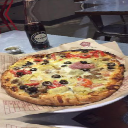

strong augmentation


tensor([[[0.6039, 0.5333, 0.5255,  ..., 0.6118, 0.5529, 0.4549],
         [0.6235, 0.5059, 0.4667,  ..., 0.6353, 0.4275, 0.3882],
         [0.6745, 0.3843, 0.4471,  ..., 0.7882, 0.6667, 0.5098],
         ...,
         [0.3373, 0.4078, 0.5020,  ..., 0.6549, 0.6510, 0.7255],
         [0.4549, 0.4667, 0.5059,  ..., 0.7373, 0.6275, 0.6510],
         [0.7216, 0.7294, 0.7137,  ..., 0.6353, 0.6667, 0.6196]],

        [[0.3961, 0.3373, 0.3059,  ..., 0.2706, 0.2706, 0.2588],
         [0.4235, 0.3608, 0.2471,  ..., 0.3529, 0.2118, 0.2000],
         [0.4627, 0.2745, 0.3412,  ..., 0.4784, 0.3020, 0.2314],
         ...,
         [0.1529, 0.2039, 0.3020,  ..., 0.3176, 0.2392, 0.3686],
         [0.2588, 0.2235, 0.2745,  ..., 0.4118, 0.2627, 0.3098],
         [0.5333, 0.5137, 0.5020,  ..., 0.2863, 0.2941, 0.2471]],

        [[0.4078, 0.3647, 0.3647,  ..., 0.3020, 0.3373, 0.3059],
         [0.4314, 0.3843, 0.3294,  ..., 0.3529, 0.2824, 0.2706],
         [0.4745, 0.2980, 0.3725,  ..., 0.4863, 0.3529, 0.

In [0]:
rand_idx = 1
# print(unlabeled_data.train_ds[rand_idx])

print("weak augmentation")
display(unlabeled_data.train_ds[rand_idx][0][0])

print("strong augmentation")
display(unlabeled_data.train_ds[rand_idx][0][1])

# display(unlabeled_data.train_ds[rand_idx][0][0].resize((1, 256, 256)))
# display(unlabeled_data.train_ds[rand_idx][0][1].resize((1, 256, 256)))

The torchvision.transforms used return tensor data.

So the data need to be converted to PIL Image for display

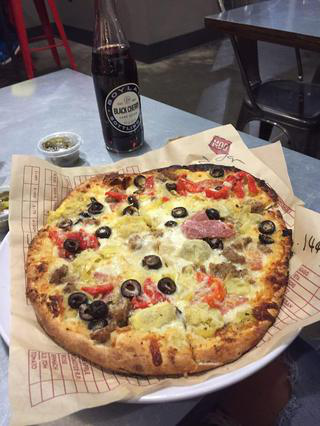

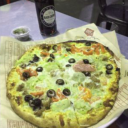

In [0]:
sample_img = unlabeled_data.train_ds.x[1]
display(sample_img)

custom_transforms = torchvision.transforms.Compose([
  get_extra_strong_transforms(),
  torchvision.transforms.ToPILImage(),
])
transformed_img = custom_transforms(sample_img.data)
display(transformed_img)

Checking the shape of a batch

In [0]:
old_bs = unlabeled_data.batch_size
ub = next(iter(unlabeled_data.train_dl))
print(ub[0].shape)
print(ub[1].shape)
print(len(ub))
# (batch_size, n_img, channel, width, height)
# weak, strong = torch.split(ub[0], 1, dim=1)
# print(weak.squeeze().shape, strong.shape)

torch.Size([32, 2, 3, 128, 128])
torch.Size([32])
2


Create the learner and pass the unlabeled data via the fixmatch call

In [0]:
# base_model = models.WideResNet(num_groups=3, N=4, num_classes=3, k=2, start_nf=32)
base_model = models.resnet18()
learn = Learner(labeled_data, base_model, metrics=accuracy).fixmatch(unlabeled_data)


In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
resnet_learning_rate = 1e-2
learn.fit_one_cycle(5, resnet_learning_rate)

labeled dataset     :           805 samples
unlabeled dataset   :         5,039 samples
labeled batch size: 16
unlabeled batch size: 32


epoch,train_loss,valid_loss,accuracy,train_Lx,train_Lu*λ,time
0,1.585044,1.266723,0.363184,1.579457,0.005586,07:09
1,1.227787,1.025841,0.542289,1.226210,0.001576,04:57
2,1.098487,1.252220,0.442786,1.096911,0.001576,05:44
3,1.034298,1.017858,0.482587,1.032948,0.001349,02:40
4,0.979464,0.966312,0.542289,0.978977,0.000486,02:21


In [0]:
private_dir = Path("/content/drive/My Drive/FellowshipAI/private")
output_dir = private_dir.joinpath("output")


In [0]:
learn.model_dir = output_dir
saved_model_path = learn.save("resnet18-size128-epochs5", return_path=True)
print(saved_model_path)

/content/drive/My Drive/FellowshipAI/private/output/resnet18-size128-epochs5.pth


In [0]:
print(len(ub))
print(type(ub[0]))
print(ub[0].shape)
print(ub[1].shape)

2
<class 'torch.Tensor'>
torch.Size([32, 2, 3, 128, 128])
torch.Size([32])


Displaying a prediction for a random validation sample

Ground truth:  dark
['dark', 'light', 'medium']
(Category medium, tensor(2), tensor([0.3207, 0.1229, 0.5565]))


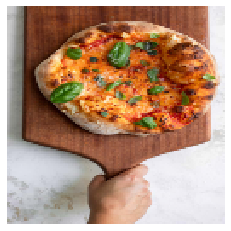

In [0]:
rand_idx = random.randint(0, len(labeled_data.valid_ds))
test_img = labeled_data.valid_ds[rand_idx][0]
show_image(test_img, figsize=(4,4))
print("Ground truth: ", labeled_data.valid_ds[rand_idx][1])

print(learn.data.classes)
print(learn.predict(test_img))
